# Image Noise Reduction using an Deep-CNN

**Author:** [Pritom Mojumder](https://github.com/ipritom)<br>
**Date created:** 2021/08/20<br>
**Description:** Implementing Noise Reducer model using Deep Convolutional Neural Network. DiV2k Dataset is utilised and gaussian noise is added to all the images manually.


In [ ]:
import tensorflow as tf

import os
import math
import numpy as np
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [ ]:
!nvidia-smi

Mon Aug 23 04:32:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Loading 
In this project DIV2K dataset have been utilised which has 800 high resolution images

In [ ]:
dataset_url = r"/content/drive/MyDrive/Project/DIV2Kpc/"

In [ ]:
img_dir = dataset_url+'noisy/'
target_dir =dataset_url+'target/'


In [ ]:
target_size=(300,300) # set this to the target size you want
channels=3 # for color images
color_mode='rgb'
shuffle=True,
seed=1337
class_mode=None
batch_size=8 # set this to desired batch size
vsplit=.2 # set this to the validation split you want



In [ ]:
gen=ImageDataGenerator(rescale=1/255, validation_split=vsplit)
image_gen=gen.flow_from_directory(img_dir, target_size=target_size, color_mode=color_mode,class_mode=class_mode,seed=seed,
                                batch_size=batch_size, subset='training')
valid_image_gen=gen.flow_from_directory(img_dir, target_size=target_size, color_mode=color_mode,class_mode=class_mode,seed=seed,
                                batch_size=batch_size, subset='validation')
target_gen=gen.flow_from_directory(target_dir,target_size=target_size, color_mode=color_mode,class_mode=class_mode,seed=seed,
                                batch_size=batch_size, subset='training') 
valid_target_gen=gen.flow_from_directory(target_dir,target_size=target_size, color_mode=color_mode,class_mode=class_mode,seed=seed,
                                batch_size=batch_size, subset='validation') 
composite_gen=zip(image_gen, target_gen)
valid_gen=zip(valid_image_gen, valid_target_gen)


Found 640 images belonging to 1 classes.
Found 160 images belonging to 1 classes.
Found 640 images belonging to 1 classes.
Found 160 images belonging to 1 classes.


In [ ]:
#Important Note : These values need to be set according to dataset size
total_train = 640
total_val = 160
upscale_factor = 1

In [ ]:
images, targets=next(composite_gen)

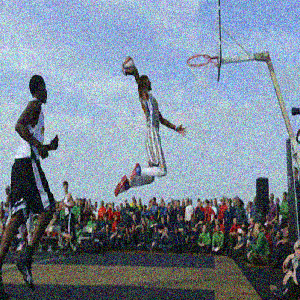

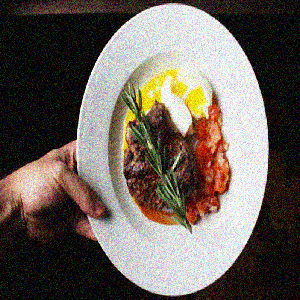

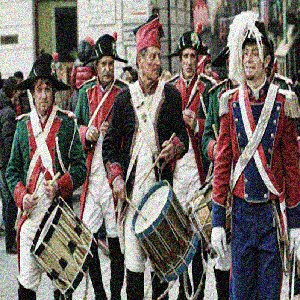

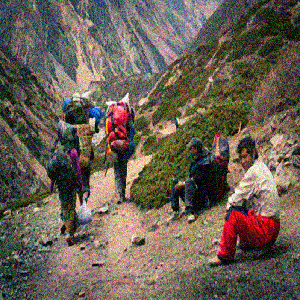

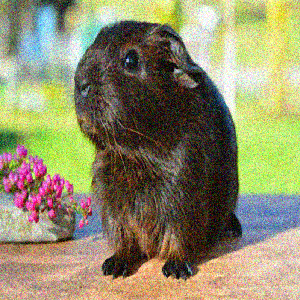

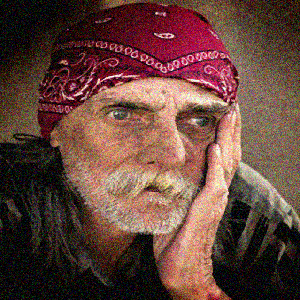

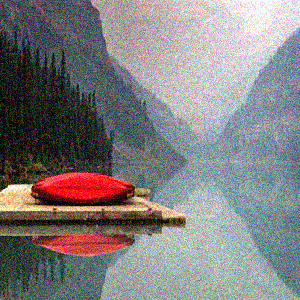

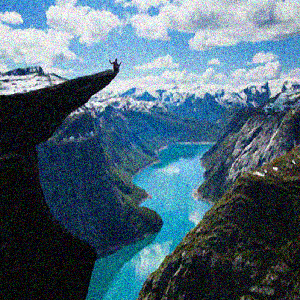

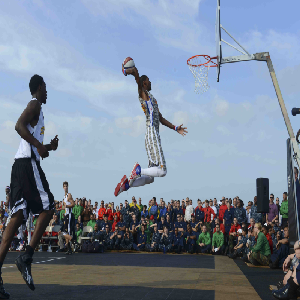

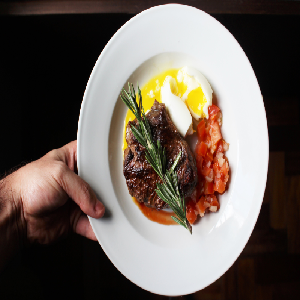

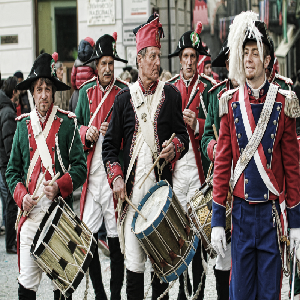

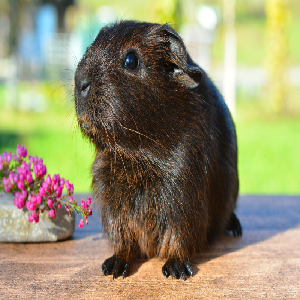

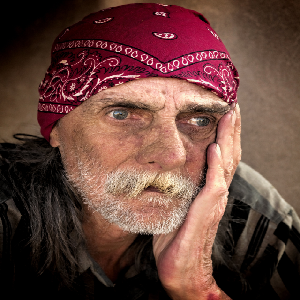

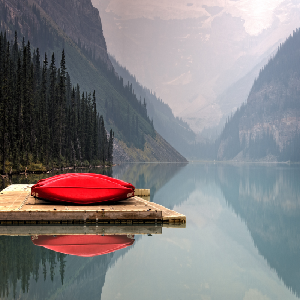

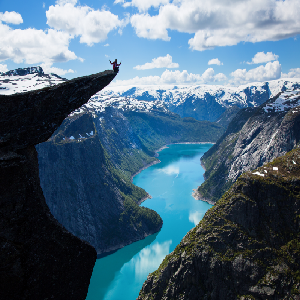

In [ ]:
for img in images:
    display(array_to_img(img))
for img in targets:
    display(array_to_img(img))

# Build DCNN model 

In [ ]:
def get_model(upscale_factor=1, channels=3):
    conv_args = {
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 7, **conv_args)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 5, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    outputs = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    # outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## Define utility functions

We need to define several utility functions to monitor our results:

- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `denoise_image` to turn a noisy image to a good version of image reconstructed by the model.


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

def denoise_image(model,img):
    """Return image passed through the given model."""

    y = img_to_array(img)
    y = y.astype("float32") / 255.0
    
    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y = out_img_y*255

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    
    return array_to_img(out_img_y)

def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

Getting the model ready for training.

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=3)
model.summary()

callbacks = [early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    9472      
_________________________________________________________________
batch_normalization_4 (Batch (None, None, None, 64)    256       
_________________________________________________________________
re_lu_4 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 128)   204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, None, 128)   512       
_________________________________________________________________
re_lu_5 (ReLU)               (None, None, None, 128)   0   

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

history = model.fit(
    composite_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen,
    steps_per_epoch=total_train // batch_size,validation_steps=total_val // batch_size
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/100
80/80 [==============================] - 591s 7s/step - loss: 0.0715 - val_loss: 0.0968
Epoch 2/100
80/80 [==============================] - 51s 638ms/step - loss: 0.0138 - val_loss: 0.0117
Epoch 3/100
80/80 [==============================] - 52s 647ms/step - loss: 0.0118 - val_loss: 0.0278
Epoch 4/100
80/80 [==============================] - 52s 650ms/step - loss: 0.0121 - val_loss: 0.0104
Epoch 5/100
80/80 [==============================] - 52s 650ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 6/100
80/80 [==============================] - 52s 651ms/step - loss: 0.0117 - val_loss: 0.0090
Epoch 7/100
80/80 [==============================] - 52s 650ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 8/100
80/80 [==============================] - 52s 649ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 9/100
80/80 [==============================] - 52s 649ms/step - loss: 0.0098 - val_loss: 0.0130
Epoch 10/100
80/80 [==============================] - 52s 650ms/step - loss: 0.0112 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','validation_loss'])

In [ ]:
project_path = 'drive/MyDrive/Project/'

In [ ]:
sample_img_path = project_path +'kids_low_q.jpg'

In [ ]:
img = load_img(sample_img_path)

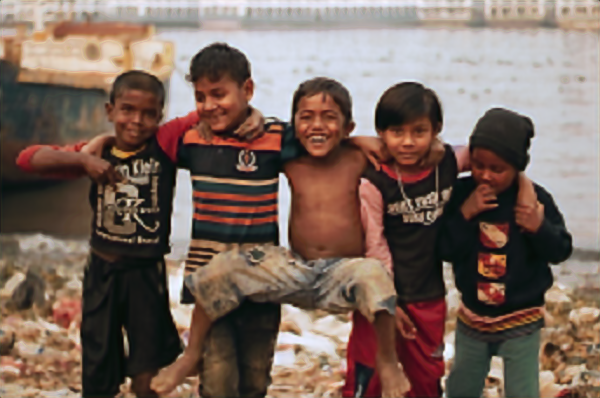

In [ ]:
predicted = denoise_image(model,img)
display(img)
display(predicted)

In [ ]:
test_psnr = tf.image.psnr(img_to_array(predicted),img_to_array(img), max_val=255)
print(f'Test PSNR',test_psnr)

Test PSNR tf.Tensor(29.862692, shape=(), dtype=float32)


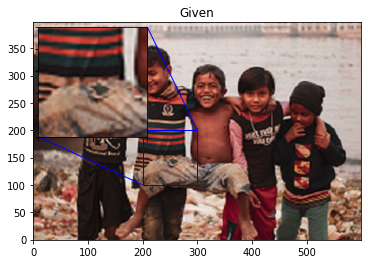

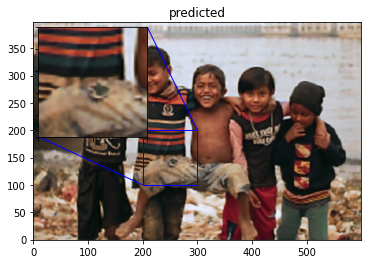

In [ ]:
plot_results(img,'oo','Given')
plot_results(predicted,'oo','predicted')